---
**SCRIPT FOR TRAINING M1 MODEL**

---

**David Norman Díaz Estrada**

davidnd@stud.ntnu.no


This scripts contains the procedure followed for training M1 model for image colorization. For the general training strategy I took inspiration from [1], and for the architecture of the model M1 the code was modified based on [2].
Model M1 was trained on **1000 images** (10% used for validation) from the Places 365 dataset [3], and with **VGG16** as the feature extractor for **global features**. Model M1 uses a **fusion module** that combines the global features extracted by VGG16 and the features extracted by a fully trainable encoder.

**References:**

[1] Bhattiprolu, S. “python for microscopists”. (2020).
https://github.com/bnsreenu/python_for_microscopists/blob/master/092-autoencoder_colorize_transfer_learning_VGG16_V0.1.py

[2] Xiangyu, “automatic image colorization using machine
learning”. (2021). https://xiangyutang2.github.io/auto-colorization-autoencoders/

[3] Bolei Zhou, Agata Lapedriza, Aditya Khosla, Aude Oliva,
and Antonio Torralba. Places: A 10 million image database
for scene recognition. IEEE Transactions on Pattern Analysis
and Machine Intelligence, 40(6):1452–1464, 2018.




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Load the training set:
!unzip '/content/gdrive/My Drive/COSI/Semestre3/VideoProcessing/places365_11k/train.zip'


Streaming output truncated to the last 5000 lines.
  inflating: train/Places365_val_00005129.jpg  
  inflating: train/Places365_val_00005130.jpg  
  inflating: train/Places365_val_00005131.jpg  
  inflating: train/Places365_val_00005132.jpg  
  inflating: train/Places365_val_00005133.jpg  
  inflating: train/Places365_val_00005134.jpg  
  inflating: train/Places365_val_00005135.jpg  
  inflating: train/Places365_val_00005136.jpg  
  inflating: train/Places365_val_00005137.jpg  
  inflating: train/Places365_val_00005138.jpg  
  inflating: train/Places365_val_00005139.jpg  
  inflating: train/Places365_val_00005140.jpg  
  inflating: train/Places365_val_00005141.jpg  
  inflating: train/Places365_val_00005142.jpg  
  inflating: train/Places365_val_00005143.jpg  
  inflating: train/Places365_val_00005144.jpg  
  inflating: train/Places365_val_00005145.jpg  
  inflating: train/Places365_val_00005146.jpg  
  inflating: train/Places365_val_00005147.jpg  
  inflating: train/Places365_val_0000

In [ ]:
#Load the testing set:
!unzip '/content/gdrive/My Drive/COSI/Semestre3/VideoProcessing/places365_11k/test.zip'



---
**Loading VGG16:**

---





In [ ]:
#Image colorization using Autoencoders. Transfer learning using VGG.


from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os

from keras.applications.vgg16 import VGG16
vggmodel = VGG16()
vggmodel.summary()
 

553476096/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
#Create a "newmodel"  without the last layers of original VGG16 architecture:
newmodel = Sequential() 
#num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<22:          #Only up to 22th layer to include feature extraction only (flattened)
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   #We don't want to train these layers again, so False.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

---
**Dataset pre-processing**

---

Data loader:

In [ ]:
#path = 'images/colorization/'
path= '/content/'

#Normalize images - divide by 255
datagenerator = ImageDataGenerator(rescale=1. / 255)


#Resize images, if needed
train_generator = datagenerator.flow_from_directory(path,
                                          batch_size=1000, #only 1000 images
                                          target_size=(224, 224),  #resizes the images to ensure dimensions are 224x224 (VGG16 requires this input size)
                                          class_mode=None,
                                          classes=["train"],
                                          shuffle='true',   #change the original order of the images for a better distribution of the training examples
                                          color_mode='rgb'
                                          )

test_generator = datagenerator.flow_from_directory(path,
                                          batch_size=1000,
                                          target_size=(224, 224),   #resizes the images to ensure dimensions are 224x224
                                          class_mode=None,
                                          classes=["test"],
                                          color_mode='rgb'
                                          )

Found 10000 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


Pre-Process Training Images:

In [ ]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X_train =[]
Y_train =[]
#counter=1
for img in train_generator[0]:
  #print("Image #: ",counter)
  #counter+=1
  try:
      lab = rgb2lab(img)
      X_train.append(lab[:,:,0]) 
      Y_train.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = X_train.reshape(X_train.shape+(1,)) #dimensions to be the same for X and Y
print(X_train.shape)
print(Y_train.shape)

(1000, 224, 224, 1)
(1000, 224, 224, 2)


In [ ]:
#now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so we repeated the L channel two times to get 3 dimensions of the same L channel

vggfeatures_train = []

for i, sample in enumerate(X_train):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  

  prediction = newmodel.predict(sample)
  #prediction = prediction.reshape((7,7,512))
  prediction = prediction.reshape((4096))
  vggfeatures_train.append(prediction)


vggfeatures_train = np.array(vggfeatures_train)
print(vggfeatures_train.shape) # for each of the input images it has a set of feature maps of size (1,4096)


(1000, 4096)


Repeat L channel 3 times:

In [ ]:
#so we repeated the L channel two times to get 3 dimensions of the same L channel

L_train = []
for i, sample in enumerate(X_train):
  sample = gray2rgb(sample)
  sample = sample.reshape((224,224,3))
  L_train.append(sample)

L_train = np.array(L_train)
print(L_train.shape) #

(1000, 224, 224, 3)


Pre-Process Testing Images:

In [ ]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X_test =[]
Y_test =[]
counter=1
for img in test_generator[0]:
  print("Image #: ",counter)
  counter+=1
  try:
      lab = rgb2lab(img)
      X_test.append(lab[:,:,0]) 
      Y_test.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = X_test.reshape(X_test.shape+(1,)) #dimensions to be the same for X and Y
print(X_test.shape)
print(Y_test.shape)

In [ ]:
#now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so we repeated the L channel two times to get 3 dimensions of the same L channel

vggfeatures_test = []
counter=1
for i, sample in enumerate(X_test):
  print("Image #: ",counter)
  counter+=1
  
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures_test.append(prediction)
vggfeatures_test = np.array(vggfeatures_test)
print(vggfeatures_test.shape) # for each of the 513 input images it has a set of feature maps of size 7x7x512

Define Function to plot accuracy and loss of Network during training:

In [ ]:
def plotHistoryNetwork(History):
  from matplotlib import pyplot as plt
  
  #Plot train and test accuracy curves:
  plt.plot(History.history['accuracy'])
  plt.plot(History.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  #Plot train and test loss curves:
  plt.figure()
  plt.plot(History.history['loss'])
  plt.plot(History.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

---
**Model M1:**

---

In [ ]:
import tensorflow as tf
import keras

#code modified based on: https://xiangyutang2.github.io/auto-colorization-autoencoders/

#%% merge model

from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import Reshape
from keras.layers.merge import concatenate
#from keras.utils import plot_model # this call was not working (probably it worked in an older version)
from keras.utils.vis_utils import plot_model
from os import listdir
from pickle import load
import numpy as np




# %%
#def define_model(img_h, img_w, feature_size):
def define_model(img_h, img_w):
    # feature extractor model
    
    #inputs1 = Input(shape=(feature_size,))
    inputs1 = Input(shape=(4096)) # I changed to this, it takes as input result of vgg16 (until last layer before prediction) with 4096 features

    #image_feature = Dropout(0.5)(inputs1)
    #image_feature = Dense(1024, activation='relu')(image_feature)
    image_feature = Dense(1024, activation='relu')(inputs1)
    
    # encoder
    
    #inputs2 = Input(shape=(img_h, img_w, 3,))
    inputs2 = Input(shape=(img_h, img_w, 3)) # modified this-------------------------------------------------------------------------------------------------------
    
    encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(inputs2)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    
    #fusion
    #concat_shape = (-1, 28,28,256) #encoder_output.shape[:3].concatenate(image_feature.shape[1])
    #image_feature = backend.repeat(image_feature, encoder_output.shape[1] * encoder_output.shape[2])
    #image_feature = backend.reshape(image_feature, shape=([-1, 28,28,256]))
    
    #concat_shape = (np.uint32(encoder_output.shape[1]), np.uint32(encoder_output.shape[2]),np.uint32(inputs1.shape[-1]))
    concat_shape = (encoder_output.shape[1], encoder_output.shape[2],inputs1.shape[-1]) # I changed to this, conversion to np.uint32 was giving error--------------------------
    
    
    image_feature = RepeatVector(concat_shape[0]*concat_shape[1])(inputs1)
    image_feature = Reshape(concat_shape)(image_feature)

    
    fusion_output = concatenate([encoder_output, image_feature], axis=3)
    
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)


    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=decoder_output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
    # summarize model
    print(model.summary())
    plot_model(model, to_file='autoencoder_colorization_merged.png', show_shapes=True)
    
    return model

In [ ]:
model_fusion = define_model(img_h=224, img_w=224)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 112, 112, 64  1792        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 112, 112, 12  73856       ['conv2d_39[0][0]']              
                                8)                                                          

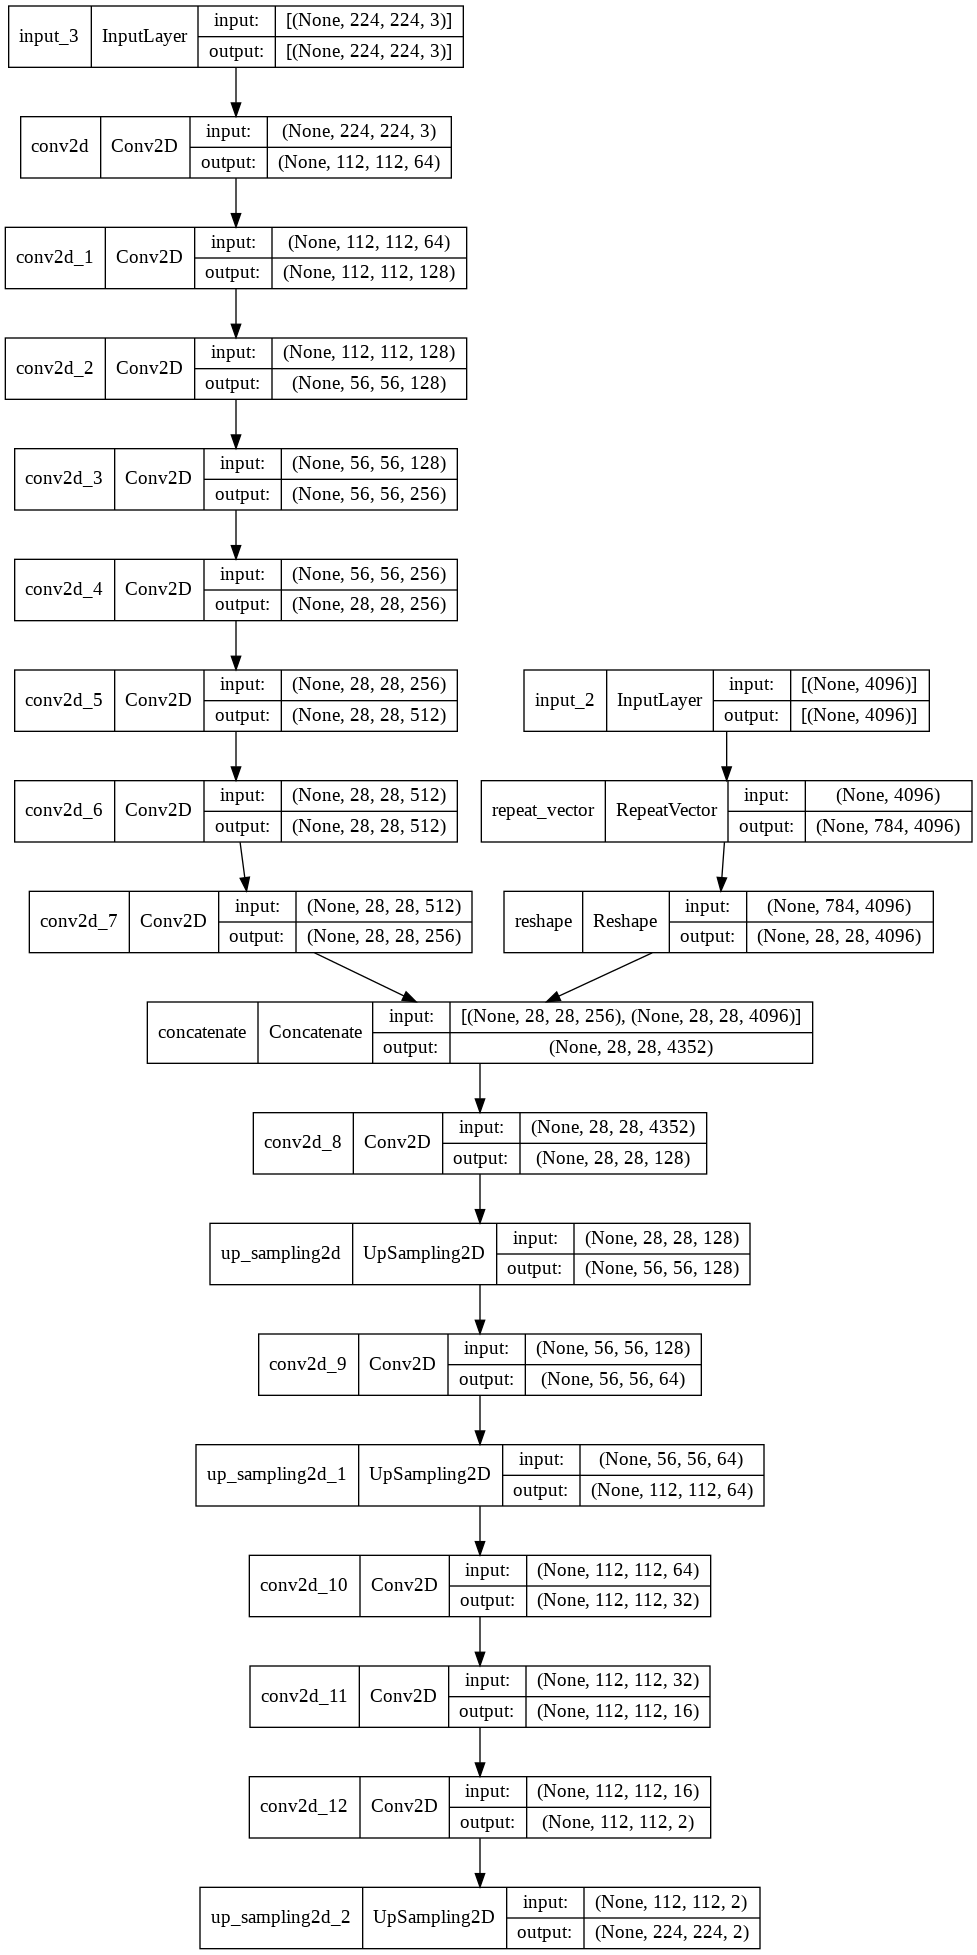

In [ ]:
plot_model(model_fusion, to_file='model_fusion_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_fusion.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
history=model_fusion.fit(x=[vggfeatures_train,L_train],y=Y_train ,validation_split=0.1, verbose=1, epochs=100, batch_size=8)

Epoch 1/100
113/113 [==============================] - 37s 262ms/step - loss: 0.9623 - accuracy: 0.3926 - val_loss: 0.9492 - val_accuracy: 0.3801
Epoch 2/100
113/113 [==============================] - 29s 257ms/step - loss: 0.9610 - accuracy: 0.3906 - val_loss: 0.9465 - val_accuracy: 0.3768
Epoch 3/100
113/113 [==============================] - 29s 255ms/step - loss: 0.9617 - accuracy: 0.3884 - val_loss: 0.9484 - val_accuracy: 0.3768
Epoch 4/100
113/113 [==============================] - 29s 255ms/step - loss: 0.9620 - accuracy: 0.3884 - val_loss: 0.9484 - val_accuracy: 0.3768
Epoch 5/100
113/113 [==============================] - 29s 255ms/step - loss: 0.9620 - accuracy: 0.3884 - val_loss: 0.9484 - val_accuracy: 0.3768
Epoch 6/100
113/113 [==============================] - 29s 256ms/step - loss: 0.9620 - accuracy: 0.3884 - val_loss: 0.9484 - val_accuracy: 0.3768
Epoch 7/100
113/113 [==============================] - 29s 256ms/step - loss: 0.9620 - accuracy: 0.3884 - val_loss: 0.9484 -

In [ ]:
#model_fusion.save("colorizer_fusionModel_train61-36_val62-53_100epochs_batch8.h5")

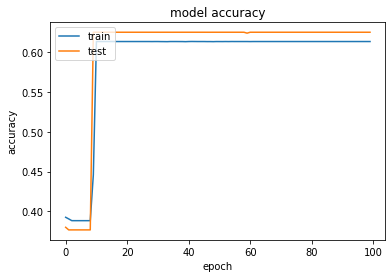

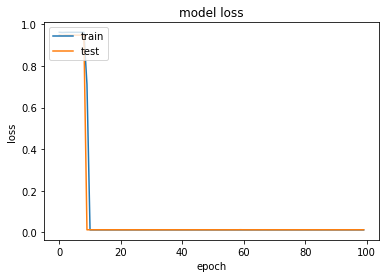

In [ ]:
plotHistoryNetwork(history)

---
**Predicting images and visualize:**

---

In [ ]:
#predict all images
ab = model_fusion.predict([vggfeatures_train,L_train])
ab = ab*128


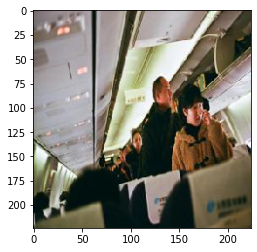

(224, 224, 3)


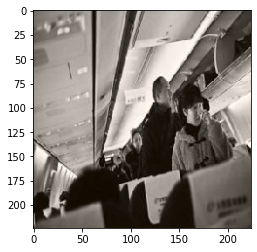

In [ ]:
# Predict and image fromt the training set:

from matplotlib import pyplot as plt

batch=0 #only one batch , then set =0
n=600 #Set image to predict,  4,5,6
img1_color=[]
img1= train_generator[batch][n]
plt.imshow(img1)
plt.show()
print(img1.shape)
#print(img1)

cur = np.zeros((224, 224, 3))
cur[:,:,0] = X_train[n].reshape(224,224)
cur[:,:,1:] = ab[n]

plt.imshow(lab2rgb(cur))
plt.show()

In [ ]:
# Predict and image from the testing set:

from matplotlib import pyplot as plt

batch=0 #only one batch , then set =0
n=15 #Set image to predict,  7, 8,9, 11,13,15
img1_color=[]
img1= test_generator[batch][n]
plt.imshow(img1)
plt.show()
print(img1.shape)
#print(img1)



#img1 is from the training set, so it is already scaled to 224x224 and scalen in RGB range [0,1]

lab = rgb2lab(img1)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))
#print(L.shape)
vggpred = newmodel.predict(L) #get features
ab = model.predict(vggpred)
#print(ab.shape)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

plt.imshow(lab2rgb(cur))
plt.show()
#imsave('images/colorization2/vgg_result/result'+str(idx)+".jpg", lab2rgb(cur))